In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pickle as pkl 
import torch
from torchvision import datasets,transforms as T
from torch.utils.data import DataLoader
from torch import optim,nn
import torch.nn.functional as F

In [2]:
transform = T.Compose([T.Pad(2),T.ToTensor()])

train_set = datasets.MNIST('MNIST_data/',train = True,download=True,transform=transform)

In [3]:
trainloader = DataLoader(train_set, batch_size=64)

torch.Size([64, 1, 32, 32])


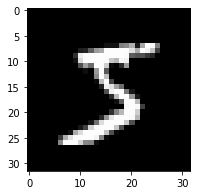

In [4]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(images.shape)
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')

In [5]:
def conv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):

    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)

    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [6]:
class Discriminator(nn.Module):

    def __init__(self,conv_dim = 32):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim

        self.conv1 = conv(in_channels = 1,out_channels = conv_dim, kernel_size = 4, batch_norm = False)
        self.conv2 = conv(in_channels = conv_dim, out_channels = conv_dim*2,kernel_size = 4)
        self.conv3 = conv(in_channels = conv_dim*2, out_channels = conv_dim*4,kernel_size = 4)

        self.fc = nn.Linear(conv_dim*4*4*4,1)

    def forward(self,x):

        a1 = F.leaky_relu(self.conv1(x),0.2)
        a2 = F.leaky_relu(self.conv2(a1),0.2)
        a3 = F.leaky_relu(self.conv3(a2),0.2)

        a3 = a3.view(-1,self.conv_dim*4*4*4)

        a4 = self.fc(a3)

        return a4


In [7]:
def deconv(in_channels, out_channels, kernel_size, stride = 2,padding = 1, batch_norm = True):

    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(transpose_conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [8]:
class Generator(nn.Module):

    def __init__(self,z_size,conv_dim = 32):
        super(Generator,self).__init__()

        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size,conv_dim*4*4*4)

        self.t_conv1 = deconv(in_channels = conv_dim*4,out_channels = conv_dim*2, kernel_size = 4)
        self.t_conv2 = deconv(in_channels = conv_dim*2,out_channels = conv_dim,kernel_size = 4)
        self.t_conv3 = deconv(in_channels = conv_dim,out_channels = 1,kernel_size = 4,batch_norm = False)

    def forward(self,x):

        a1 = self.fc(x)
        a1 = a1.view(-1,self.conv_dim*4,4,4)

        a2 = F.relu(self.t_conv1(a1))
        a2 = F.relu(self.t_conv2(a2))

        a3 = self.t_conv3(a2)
        a3 = torch.tanh(a3)

        return a3


In [9]:
D = Discriminator(32)
G = Generator(z_size=100, conv_dim=32)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [10]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


In [11]:
def real_loss(D_out, smooth = False):
    
    batch_size = D_out.size(0)
    if smooth:

        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)

    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(),labels)
    return loss

In [12]:
def fake_loss(D_out):

    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)

    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [13]:
lr = 0.0001

beta_1 = 0.5
beta_2 = 0.999

d_optimizer = optim.Adam(D.parameters(),lr,[beta_1,beta_2])
g_optimizer = optim.Adam(G.parameters(),lr,[beta_1,beta_2])

In [14]:
samples = []
losses = []
epochs = 50
print_every = 400

sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, 100))
fixed_z = torch.from_numpy(fixed_z).float()

for epoch in range(epochs):

    for batch_id, (real_images,_) in enumerate(trainloader):

        batch_size = real_images.size(0)
        real_images = real_images*2 - 1

        d_optimizer.zero_grad()

        if train_on_gpu:
            real_images = real_images.cuda()

        D_real = D(real_images)
        d_real_loss = real_loss(D_real,smooth = True)

        z = np.random.uniform(-1,1,size=(batch_size,100))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()

        fake_images = G(z)
        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()

        z = np.random.uniform(-1,1,size = (batch_size,100))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()

        fake_images = G(z)

        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)

        g_loss.backward()
        g_optimizer.step()

        if batch_id % print_every == 0:
            print('Epoch {:5d}/{:5d} | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, epochs, d_loss.item(), g_loss.item()))

    
    losses.append((d_loss.item(),g_loss.item()))

    G.eval()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()

Epoch     1/   50 | d_loss: 1.4122 | g_loss: 0.8233
Epoch     1/   50 | d_loss: 0.4489 | g_loss: 3.9284
Epoch     1/   50 | d_loss: 0.5485 | g_loss: 2.6005
Epoch     2/   50 | d_loss: 0.5289 | g_loss: 2.4927
Epoch     2/   50 | d_loss: 0.5449 | g_loss: 2.6220
Epoch     2/   50 | d_loss: 0.5850 | g_loss: 2.6748
Epoch     3/   50 | d_loss: 0.6562 | g_loss: 2.3807
Epoch     3/   50 | d_loss: 0.6670 | g_loss: 2.2607
Epoch     3/   50 | d_loss: 0.6119 | g_loss: 2.3904
Epoch     4/   50 | d_loss: 0.6219 | g_loss: 1.2999
Epoch     4/   50 | d_loss: 1.0052 | g_loss: 2.6429
Epoch     4/   50 | d_loss: 0.6372 | g_loss: 2.4837
Epoch     5/   50 | d_loss: 0.5531 | g_loss: 2.0126
Epoch     5/   50 | d_loss: 0.7546 | g_loss: 2.5835
Epoch     5/   50 | d_loss: 0.6894 | g_loss: 2.5306
Epoch     6/   50 | d_loss: 0.6839 | g_loss: 1.5439
Epoch     6/   50 | d_loss: 0.7422 | g_loss: 2.8809
Epoch     6/   50 | d_loss: 0.7012 | g_loss: 3.3344
Epoch     7/   50 | d_loss: 0.5972 | g_loss: 2.0257
Epoch     7/

In [15]:
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

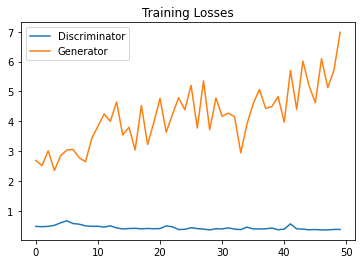

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator') 
plt.title("Training Losses")
plt.legend()

In [17]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        img = img.cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32)), cmap='Greys_r')

In [18]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

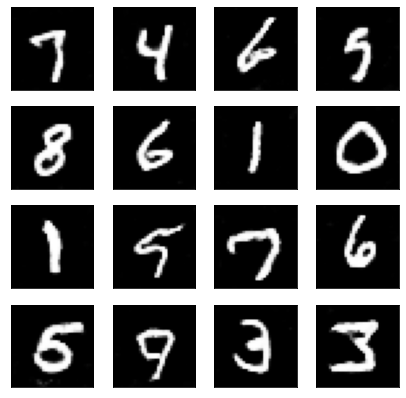

In [24]:
view_samples(29, samples)

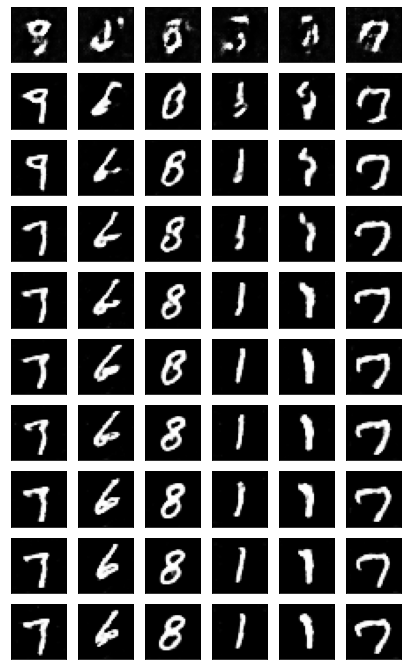

In [25]:
rows = 10
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        img = img.cpu()
        ax.imshow(img.reshape((32,32)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)